In [3]:
import os
import sys
import json
from datetime import datetime
import matplotlib.pyplot as plt
from stable_baselines3 import DQN
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.callbacks import EvalCallback
from stable_baselines3.common.monitor import Monitor

In [4]:
# Add the `src` folder to the Python path
current_dir = os.getcwd() 
src_path = os.path.join(current_dir, 'src')
sys.path.append(src_path)
import environment_gym as env_gym
import utilities as util
print("Modules imported successfully!")
# Load the TensorBoard extension
# %load_ext tensorboard

Modules imported successfully!


## Train Baseline PPO Model

In [3]:
# Initialize and vectorize the environment
env = env_gym.TrafficEnvironment()
check_env(env, warn=True)
eval_env = Monitor(env_gym.TrafficEnvironment())

# Set up log directory
log_dir = "./logs/dqn_baseline_model/"
if not os.path.exists(log_dir):
    os.makedirs(log_dir)
os.makedirs(log_dir + "best_model/", exist_ok=True)
os.makedirs(log_dir + "final_model/", exist_ok=True)

# Define the DQN model with MlpPolicy (a policy network that works well with continuous environments)
model = DQN(policy = "MlpPolicy",
            env = env, 
            verbose = 1,
           )

# Set up evaluation callback
eval_callback = EvalCallback(
    eval_env,
    best_model_save_path=log_dir + "best_model/",
    log_path=log_dir + "results/",
    eval_freq=1000,  # Evaluate the model every 1000 steps
    deterministic=True,
    render=False
)

# Train the DQN model
total_timesteps = 100000
model.learn(total_timesteps=total_timesteps, callback=eval_callback)

# Save the final model
final_model_path = log_dir + "final_model"
model.save(final_model_path)
print(f"Final model saved to {final_model_path}")

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Eval num_timesteps=1000, episode_reward=-12441.00 +/- 11632.34
Episode length: 1611.40 +/- 1154.74
-----------------------------------
| eval/               |           |
|    mean_ep_length   | 1.61e+03  |
|    mean_reward      | -1.24e+04 |
| rollout/            |           |
|    exploration_rate | 0.905     |
| time/               |           |
|    total_timesteps  | 1000      |
| train/              |           |
|    learning_rate    | 0.0001    |
|    loss             | 5.07      |
|    n_updates        | 224       |
-----------------------------------
New best mean reward!
Eval num_timesteps=2000, episode_reward=-10746.00 +/- 7833.44
Episode length: 1461.60 +/- 779.70
-----------------------------------
| eval/               |           |
|    mean_ep_length   | 1.46e+03  |
|    mean_reward      | -1.07e+04 |
| rollout/            |           |
|    exploration_rate | 0.81      |
| t

In [4]:
# Start TensorBoard to monitor logs
# %tensorboard --logdir ./logs/ppo_baseline_model/ --port=5002

## Test the Best Baseline Model

In [5]:
# Load the best baseline model
log_dir = "./logs/dqn_baseline_model/"
model_path = log_dir + 'best_model/best_model.zip'
model = DQN.load(model_path)

# Create test environment
env_test = env_gym.TrafficEnvironment()

In [6]:
# Test the model
num_episodes = 1000
file_name = 'dqn_baseline_best_model_test_log.json'
rewards, timesteps = util.test_model(model=model, env=env_test, num_episodes=num_episodes, output_file=file_name)

Average reward of 1000 episodes is -5125.
Average timesteps of 1000 episodes is 887.


## Analysis of Test Results

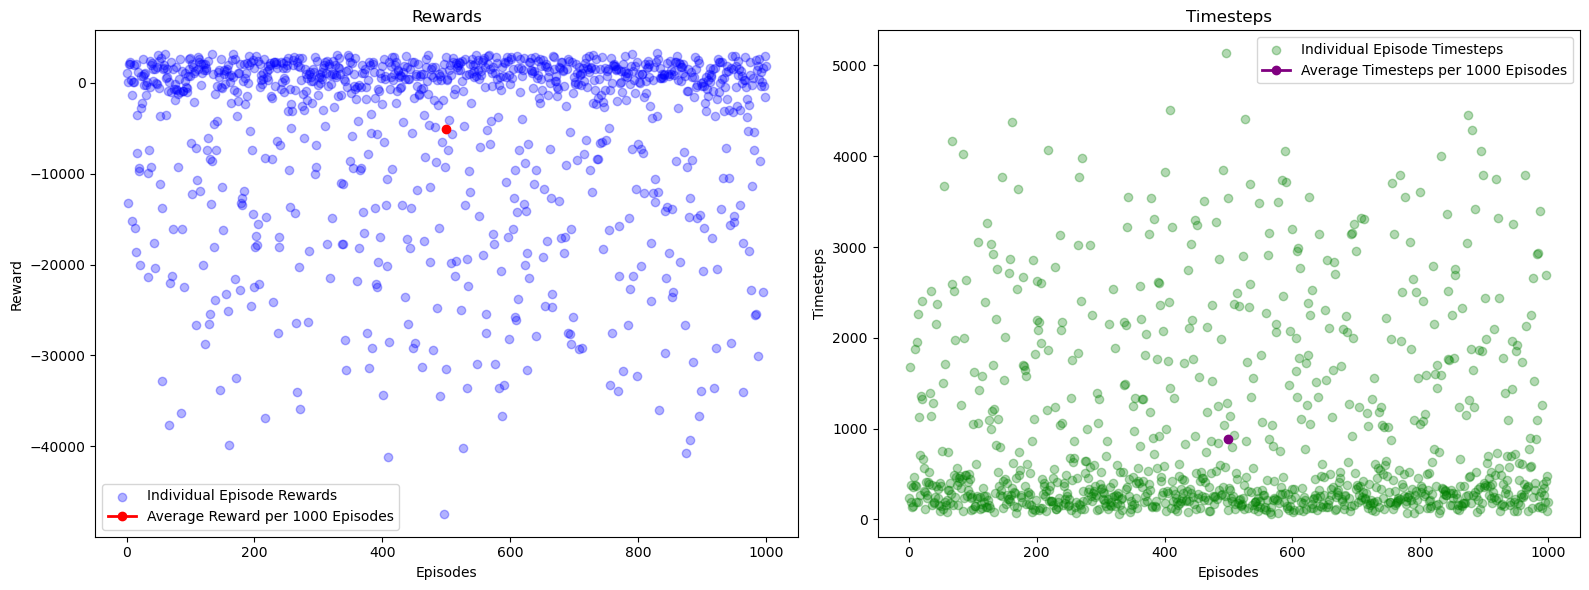

In [7]:
util.plot_test_dotplots(rewards=rewards, timesteps=timesteps, interval=1000)

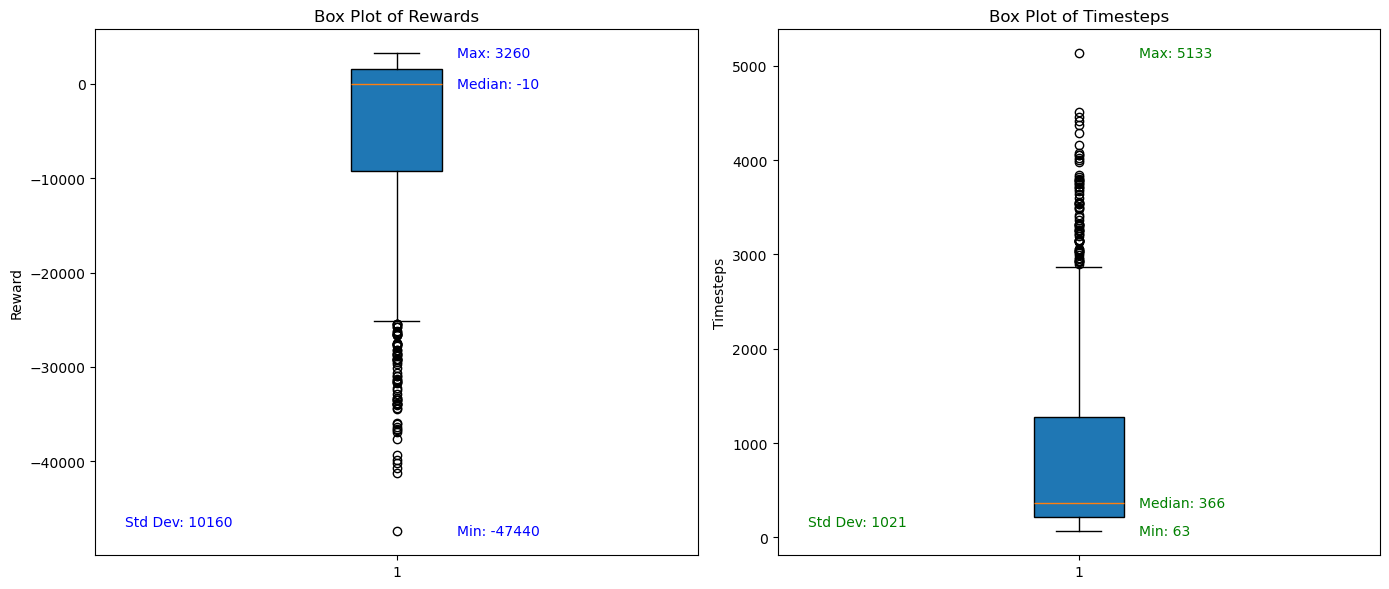

In [8]:
file_name = 'dqn_baseline_best_model_test_log.json'
util.plot_test_boxplots(json_file=file_name)

In [9]:
util.calculate_action_percentages(log_file=file_name)

Total actions across 1000 episodes: 886577
Action -1: 3.7%
Action 0: 94.2%
Action 1: 2.2%


## Analysis of Clerance Rates

In [10]:
util.calculate_clearance_rate_percentages(log_file=file_name)

Total timesteps across 1000 episodes (including initial states): 887577
Lane 1:
  76.0% of timesteps had a clearance rate less than 5
  87.1% of timesteps had a clearance rate less than 10
Lane 2:
  75.5% of timesteps had a clearance rate less than 5
  86.7% of timesteps had a clearance rate less than 10
Lane 3:
  75.3% of timesteps had a clearance rate less than 5
  86.7% of timesteps had a clearance rate less than 10
Lane 4:
  75.4% of timesteps had a clearance rate less than 5
  86.6% of timesteps had a clearance rate less than 10
Lane 5:
  75.9% of timesteps had a clearance rate less than 5
  86.9% of timesteps had a clearance rate less than 10


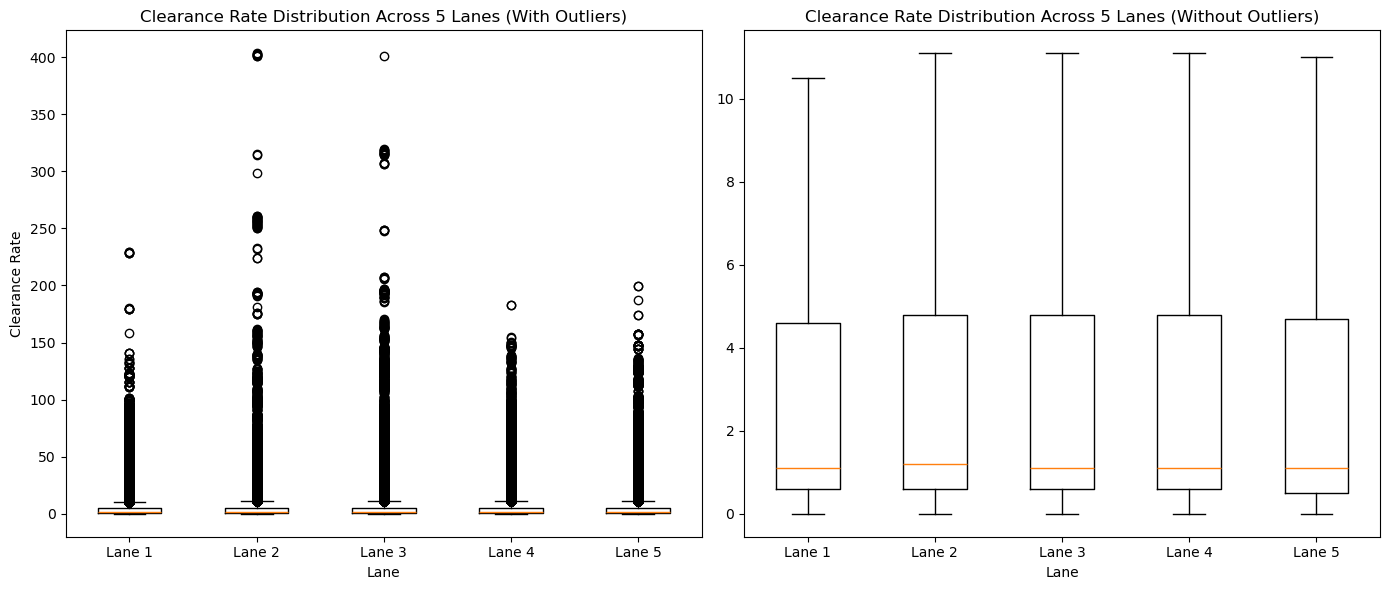

In [11]:

util.plot_clearance_rate_boxplots(log_file=file_name)

In [12]:
import optuna
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.evaluation import evaluate_policy
import os

def optimize_dqn(trial):
    # Define hyperparameters to search
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-2, log=True)
    buffer_size = trial.suggest_categorical('buffer_size', [50000, 100000, 200000])
    learning_starts = trial.suggest_categorical('learning_starts', [1000, 5000, 10000])
    batch_size = trial.suggest_categorical('batch_size', [32, 64, 128])
    gamma = trial.suggest_float('gamma', 0.8, 0.999)
    
    # Initialize environment and wrap it for monitoring
    env = Monitor(env_gym.TrafficEnvironment())
    
    # Initialize the DQN model with suggested hyperparameters
    model = DQN(
        "MlpPolicy",
        env,
        learning_rate=learning_rate,
        buffer_size=buffer_size,
        learning_starts=learning_starts,
        batch_size=batch_size,
        gamma=gamma,
        verbose=0
    )
    
    # Train model for a fixed number of timesteps
    model.learn(total_timesteps=20000)
    
    # Evaluate the model and return the mean reward for optimization
    mean_reward, _ = evaluate_policy(model, env, n_eval_episodes=5)
    return mean_reward

# Set up Optuna study with early stopping
study = optuna.create_study(study_name="DQN_Optimization", direction="maximize")


# Define an early stopping callback
def stop_early(study, trial):
    # Customize your early stopping condition here
    # For example, if the best trial reward surpasses 200, stop further trials
    if trial.number >= 10 and study.best_value > 200:
        return True
    return False

# Run the optimization with the early stopping callback
study.optimize(optimize_dqn, n_trials=50, callbacks=[stop_early])

# Display best parameters
print("Best hyperparameters:", study.best_params)

# Train a final model with the best parameters
best_params = study.best_params
final_env = Monitor(env_gym.TrafficEnvironment())

final_model = DQN(
    "MlpPolicy",
    final_env,
    **best_params,
    verbose=1
)

# Use the same evaluation callback as in your original code
eval_callback = EvalCallback(
    eval_env,
    best_model_save_path=log_dir + "best_model_optuna/",
    log_path=log_dir + "results_optuna/",
    eval_freq=1000,
    deterministic=True,
    render=False
)

# Train the model with optimized hyperparameters
final_model.learn(total_timesteps=total_timesteps, callback=eval_callback)

# Save the final model
final_model_path = log_dir + "final_model_optuna"
final_model.save(final_model_path)
print(f"Final model saved to {final_model_path}")

[I 2024-11-10 12:39:21,793] A new study created in memory with name: DQN_Optimization
[I 2024-11-10 12:39:39,132] Trial 0 finished with value: -2550.0 and parameters: {'learning_rate': 6.391764092523245e-05, 'buffer_size': 100000, 'learning_starts': 10000, 'batch_size': 128, 'gamma': 0.9854544961551501}. Best is trial 0 with value: -2550.0.
[I 2024-11-10 12:40:08,187] Trial 1 finished with value: -4526.0 and parameters: {'learning_rate': 1.1065560935466025e-05, 'buffer_size': 200000, 'learning_starts': 1000, 'batch_size': 64, 'gamma': 0.9110720118177342}. Best is trial 0 with value: -2550.0.
[I 2024-11-10 12:40:31,197] Trial 2 finished with value: -2669.0 and parameters: {'learning_rate': 1.5023104716553393e-05, 'buffer_size': 50000, 'learning_starts': 5000, 'batch_size': 32, 'gamma': 0.8589157395074501}. Best is trial 0 with value: -2550.0.
[I 2024-11-10 12:40:57,789] Trial 3 finished with value: -14200.0 and parameters: {'learning_rate': 0.005534795307088998, 'buffer_size': 100000, '

Best hyperparameters: {'learning_rate': 0.002934082509091998, 'buffer_size': 200000, 'learning_starts': 10000, 'batch_size': 64, 'gamma': 0.9876476241985358}
Using cuda device
Wrapping the env in a DummyVecEnv.
Eval num_timesteps=1000, episode_reward=587.00 +/- 1871.79
Episode length: 341.00 +/- 187.06
----------------------------------
| eval/               |          |
|    mean_ep_length   | 341      |
|    mean_reward      | 587      |
| rollout/            |          |
|    exploration_rate | 0.905    |
| time/               |          |
|    total_timesteps  | 1000     |
----------------------------------
New best mean reward!
Eval num_timesteps=2000, episode_reward=-2267.00 +/- 4950.21
Episode length: 626.20 +/- 495.38
-----------------------------------
| eval/               |           |
|    mean_ep_length   | 626       |
|    mean_reward      | -2.27e+03 |
| rollout/            |           |
|    exploration_rate | 0.81      |
| time/               |           |
|    total_t

In [6]:
# Load the best optuna model
log_dir = "./logs/dqn_baseline_model/"
model_path = log_dir + 'final_model_optuna.zip'
model = DQN.load(model_path)

# Create test environment
env_test = env_gym.TrafficEnvironment()

In [7]:
# Test the model
num_episodes = 1000
file_name = 'dqn_baseline_best_optuna_model_test_log.json'
rewards, timesteps = util.test_model(model=model, env=env_test, num_episodes=num_episodes, output_file=file_name)

Average reward of 1000 episodes is -6639.
Average timesteps of 1000 episodes is 1064.


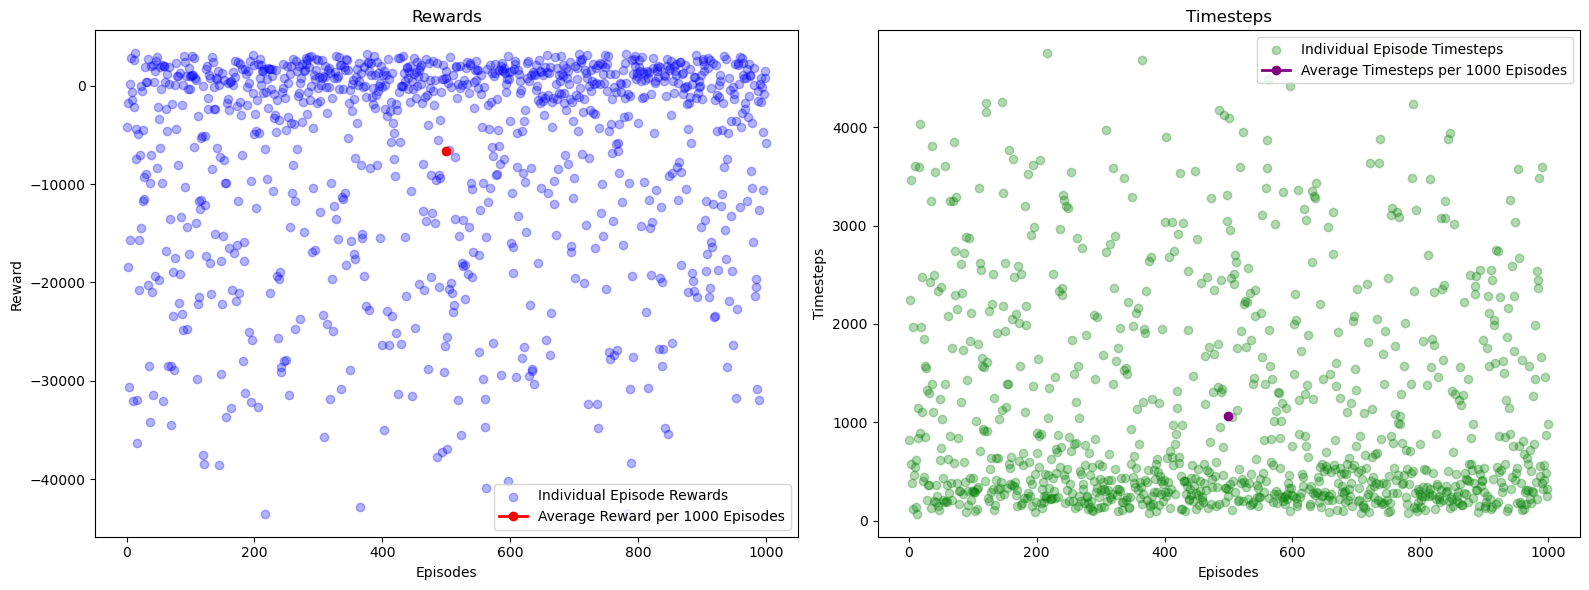

In [8]:
util.plot_test_dotplots(rewards=rewards, timesteps=timesteps, interval=1000)

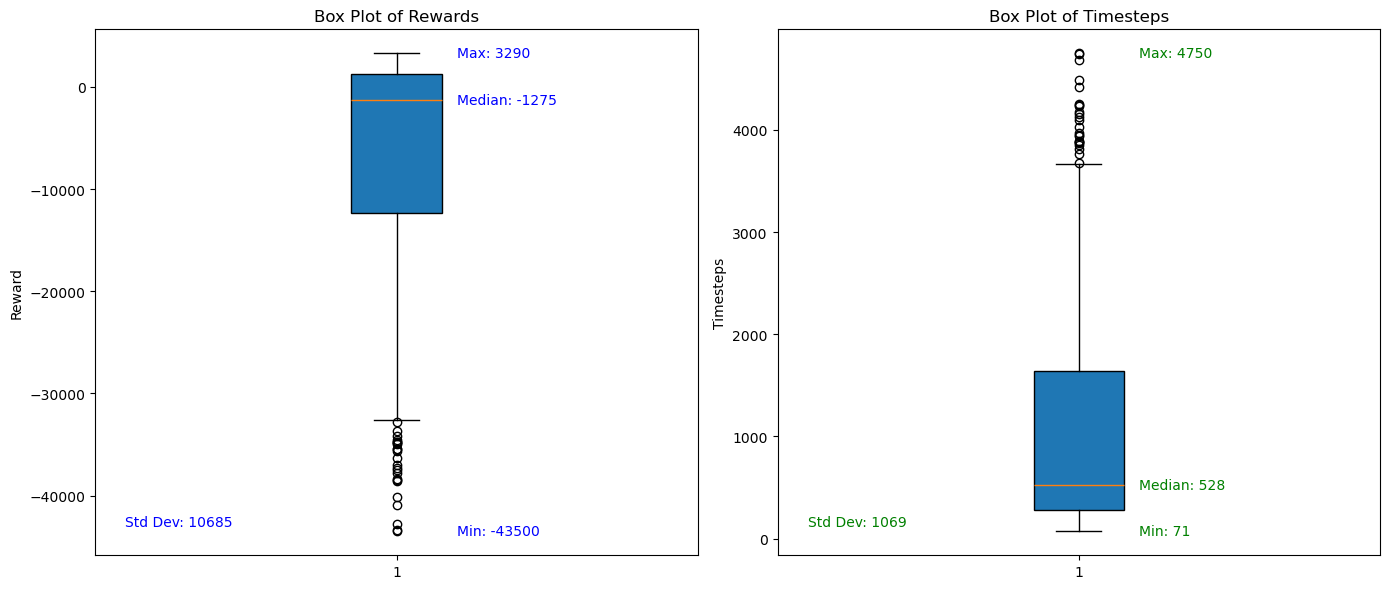

In [9]:
file_name = 'dqn_baseline_best_optuna_model_test_log.json'
util.plot_test_boxplots(json_file=file_name)

In [10]:
util.calculate_action_percentages(log_file=file_name)

Total actions across 1000 episodes: 1063892
Action -1: 0.0%
Action 0: 100.0%
Action 1: 0.0%


In [11]:
util.calculate_clearance_rate_percentages(log_file=file_name)

Total timesteps across 1000 episodes (including initial states): 1064892
Lane 1:
  77.6% of timesteps had a clearance rate less than 5
  88.4% of timesteps had a clearance rate less than 10
Lane 2:
  77.3% of timesteps had a clearance rate less than 5
  88.2% of timesteps had a clearance rate less than 10
Lane 3:
  77.2% of timesteps had a clearance rate less than 5
  87.9% of timesteps had a clearance rate less than 10
Lane 4:
  77.2% of timesteps had a clearance rate less than 5
  87.8% of timesteps had a clearance rate less than 10
Lane 5:
  77.6% of timesteps had a clearance rate less than 5
  87.8% of timesteps had a clearance rate less than 10


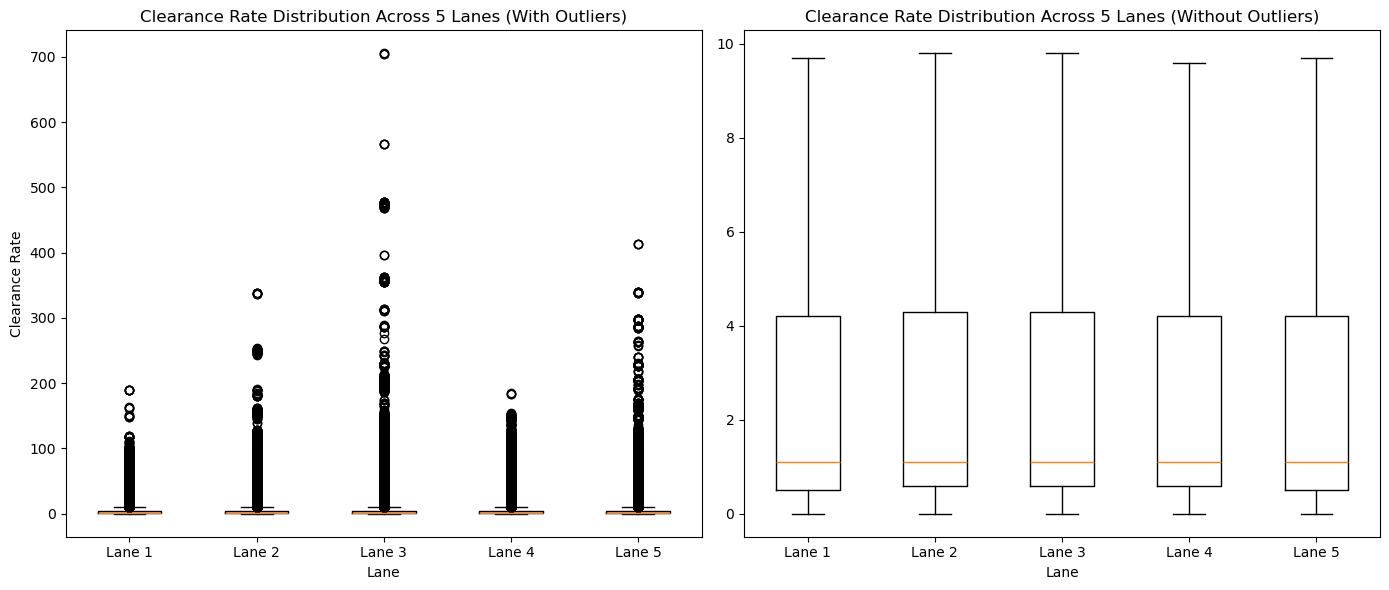

In [12]:
util.plot_clearance_rate_boxplots(log_file=file_name)